初期状態を選択(1:ガウス波束, 2:平面波) 1
壁を選択(0:なし, 1:斜め, 2:真っ直ぐ, 3:ポール) 3


NameError: name 'HTML' is not defined

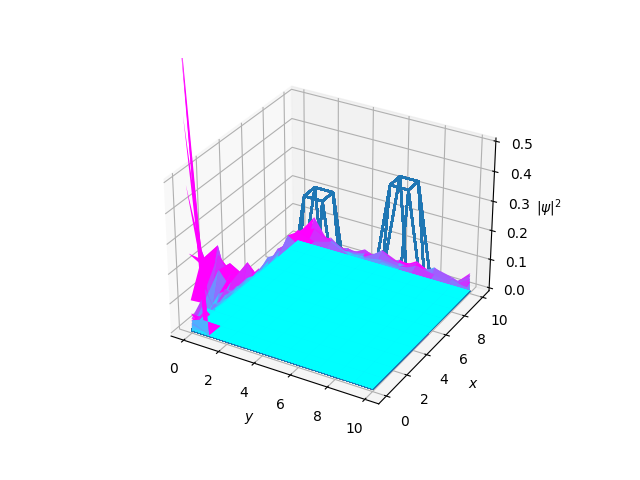

In [20]:
"""
量子ダイナミクスシミュレーション (2次元)
"""
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.animation as animation
import matplotlib.style as mplstyle


def set_initial_conditions(N, X, Y):
    """
    初期状態のセット

    Args:
        N(int): 行列サイズ
        X,Y : 位置座標
        
    Reterns:
        ndarray: 初期状態(N x N)
    """
    
    sigma = 0.05 * N
    x0 = N * 0   #波束の初期中心
    y0 = N * 0 
    psi0 = 0
    px = 10
    py = 10

    ic = int(input('初期状態を選択(1:ガウス波束, 2:平面波)'))

    if ic == 1:     #ガウス波束
        psi0 = np.exp(-((X - x0) ** 2 + (Y - y0) ** 2) / sigma ** 2) *np.exp(-1j * px * (X - x0))*np.exp(-1j * py * (Y - y0))
    if ic == 2:     #平面波
        psi0 = np.zeros((N, N))
        for i in range(N):
            psi0[i, 0] = 1

    return psi0
        

def set_initial_wave_function(ham, psi0, Nt, N, Delta):
    """
    波動関数の初期化

    Args:
        ham (csr_matrix): ハミルトニアン (疎行列 N * N)
        psi0 (ndarray): 初期波動関数
        N (int): 行列サイズ
        Nt (int): 時間分割数
        Delta (float): Δ

    Returns:
        ndarray: 波動関数 (時刻0,1のみセット), psi[時刻, サイト] (Nt x N x N)
    """
    psi = np.zeros(((Nt, N, N)), dtype="complex")

    psi0 = psi0 / np.linalg.norm(psi0)
    psi[0] = psi0
    
    hpsi = -(1j * Delta) * ham.dot(psi0)
    psi1 = psi0 + hpsi - (0.5 * 1j * Delta) * ham.dot(hpsi)
    psi1 = psi1 / np.linalg.norm(psi1)
    psi[1] = psi1
    
    return psi


def set_hamiltonian(N, periodic=True, impu=True, wall=True):
    """
    ハミルトニアンとポテンシャルのセット

    Args:
        N (int): 行列サイズ
        periodic (bool, optional): 周期境界条件 ?

    Returns:
        csr_matrix: ハミルトニアン行列 (疎行列 N * N)
    """
    t = 2.0
    v = 0.0
    data = [-t] * (N - 1) + [-t] * (N - 1)
    row = list(range(N - 1)) + list(range(1, N))
    col = list(range(1, N)) + list(range(N - 1))
    if periodic:
        data = data + [-t, -t]
        row = row + [0, N - 1]
        col = col + [N - 1, 0]

    V = np.full((N, N), v)
    if impu:                                #不純物のセット
        w = int(input('結晶の乱れ具合'))
        for i in range(N):
            for j in range(N):
                V[i, j] = w * (float(np.random.rand(1)) - 0.5)
                
    if wall:
        k = int(input('壁を選択(0:なし, 1:斜め, 2:真っ直ぐ, 3:ポール)'))

        if k == 0:
            V = V
        if k == 1:
            for i in range(N):
                if i != N // 2:
                    V[i, N - i - 1] = 5

        if k == 2:
            for i in range(N):
                if i < 0.2*N  or  0.4*N < i < 0.6*N  or  0.7*N < i:
                    V[i, N // 2] = 5

        if k == 3:
            V[int(0.7 * N):int(0.7 * N)+2, int(0.7 * N):int(0.7 * N)+2] = 4
            V[int(0.4 * N):int(0.4 * N)+2 , int(0.4 * N):int(0.4 * N)+2] = 4
        
    ham = csr_matrix((data, (row, col)))
    ham.resize((N, N))

    ham = ham.toarray()

    return ham, V, k


def time_evolution(ham, psi0, psi1, Delta, V):
    """
    時間発展

    Args:
        ham (csr_matrix): ハミルトニアン行列 (疎行列 N * N)
        psi0 (ndarray): 波動関数 (時刻 t-1)
        psi1 (ndarray): 波動関数 (時刻 t)
        Delta (float): Δ

    Returns:
        ndarray: 波動関数 (時刻 t+1)
    """
    psi2 = psi0 - (2.0 * 1j * Delta) * ham.dot(psi1) - (2.0 * 1j * Delta) * psi1.dot(ham) - (2.0 * 1j * Delta) * V * psi1
    psi2 = psi2 / np.linalg.norm(psi2)

    return psi2


def plot_animation(figure, ax, N, xv, yv, Nt, psi, V, k):
    X, Y = np.meshgrid(xv, yv)
    ims = []
    
    wall = np.zeros(((Nt, N, N)))    #壁の作成
    for i in range(Nt):
        wall[i] = 0.05 * V 
    
    for i in range(Nt):
        im0 = ax.plot_surface(X, Y, np.abs(psi[i]) ** 2, cmap = 'cool')
        im1 = ax.plot_wireframe(X, Y, wall[i])
        if k==0:
            ims.append([im0])
        else:
            ims.append([im0] + [im1])
                  
                   
    ax.set_xlabel('$y$', fontsize = 10)
    ax.set_ylabel('$x$', fontsize = 10)
    ax.set_zlim3d(0, 0.5)
    ax.zaxis.set_rotate_label(False)      #z軸ラベルを縦にする
    ax.set_zlabel('$|ψ|^2$', fontsize = 10)
    ani = animation.ArtistAnimation(figure, ims, repeat = False)

    return ani

%matplotlib widget
def main():
    """
    メイン関数
    """
    Nx = 11  # 1次元サイト数
    Ny = 11
    Nt = 100  # 時刻の最大値
    Delta = 0.1  # Δ

    xv = np.array(range(Nx))  # 位置座標のセット
    yv = np.array(range(Ny))
    Y, X = np.meshgrid(yv, xv)
    tv = np.array(range(Nt)) * Delta  # 時刻のセット
    
    psi0 = set_initial_conditions(Nx, X, Y)  # 初期状態のセット
    ham, V, k = set_hamiltonian(Nx, periodic=False, impu=False, wall=True)  # ハミルトニアンの生成
    psi = set_initial_wave_function(ham, psi0, Nt, Nx, Delta)  # 初期波動関数の準備

    for t in range(Nt - 2):  #  時間発展
        psi[t + 2] = time_evolution(ham, psi[t], psi[t + 1], Delta, V)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')
    ani = plot_animation(fig, ax, Nx, xv, yv, Nt, psi, V, k)  # 確率密度の時間発展アニメーション
    HTML(ani.to_html5_video())

    plt.show()
# ==================================================

main()